# 2D Convolutions

In [7]:
# setup

import numpy as np, pickle
import matplotlib.pyplot as plt
from matplotlib import rcParams
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
from utils import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

params = {
   'axes.labelsize': 16,
   'font.size': 16,
   'legend.fontsize': 16,
   'xtick.labelsize': 13,
   'ytick.labelsize': 13,
   'text.usetex': False,
    'font.family':"sans-serif",
   'font.sans-serif':'Arial',
   'text.usetex': False,
   }

rcParams.update(params)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

def get_variable(shape):
    initial = tf.random_normal(shape)
    return tf.Variable(initial)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [4]:
def regularize(loss, weights, reg_kind=None, reg_value=None):
    if reg_kind is None:
        return loss
    else:
        raise ValueError("Invalid value for parameter: reg_kind")

# 2D-Convolutional

In [62]:
def convolutional(pool=4, num_channels=10, verbose=True,return_weights=False,reg_kind=None, reg_value=None, filter_size=3):

    d = int(784/pool**2)
    x = tf.placeholder(tf.float32, [None, 784])

    #hidden layer
    W_conv = get_variable([filter_size, filter_size, 1, num_channels])
    b_conv = get_variable([num_channels])
    #h_fc1 = tf.sigmoid(tf.matmul(x, W_fc1) + b_fc1)

    x_reshaped = tf.reshape(x, [-1, 28, 28, 1])
    x_reshaped = tf.nn.max_pool(x_reshaped, [1, pool, pool,1], [1, pool, pool, 1], padding='SAME')
    #x_reshaped = tf.reshape(x_reshaped, [-1, d])

    h = tf.nn.conv2d(x_reshaped, W_conv, [1, 1, 1, 1], "SAME")
    h = tf.nn.sigmoid(h + b_conv)

    #output layer
    W_fc2 = get_variable([d*num_channels, 10])
    b_fc2 = get_variable([10])
    y = tf.matmul(tf.reshape(h, [-1, d*num_channels]), W_fc2) + b_fc2

    y_ = tf.placeholder(tf.float32, [None, 10])
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
    loss = regularize(loss, W_fc2, reg_kind, reg_value)
    train_step = tf.train.GradientDescentOptimizer(3.0).minimize(loss)

    with tf.Session() as sess:
        tf.global_variables_initializer().run()

        correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        for i in range(1500):
            batch = mnist.train.next_batch(100)
            train_step.run(feed_dict={x: batch[0], y_: batch[1]})
            if i%100==0:
                accuracy_train = accuracy.eval(feed_dict={x: mnist.train.images, y_: mnist.train.labels})
                accuracy_valid = accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels})
                if verbose:
                    print('Train acc:',accuracy_train, 'Valid acc:',accuracy_valid)
                
        return_values = [accuracy_train, accuracy_valid]
        if return_weights:
            return_values.append(sess.run(W_conv))
    
    return return_values

In [54]:
accuracy_train, accuracy_valid, weights = convolutional(return_weights=True, filter_size=5, num_channels=20)

Train acc: 0.17616364 Valid acc: 0.1793
Train acc: 0.6310545 Valid acc: 0.6304
Train acc: 0.75885457 Valid acc: 0.7668
Train acc: 0.7923091 Valid acc: 0.7999
Train acc: 0.80563635 Valid acc: 0.8096
Train acc: 0.8122727 Valid acc: 0.8113
Train acc: 0.81856364 Valid acc: 0.8176
Train acc: 0.83172727 Valid acc: 0.836
Train acc: 0.8301273 Valid acc: 0.8314
Train acc: 0.8268545 Valid acc: 0.827


In [ ]:
for filter_size in [3,4,5]:
    for num_channels in [5, 10, 20, 32, 64, 128]:
        accuracy_train, accuracy_valid = convolutional(verbose=False, filter_size=filter_size, 
                                                       num_channels=num_channels)
        print(filter_size, num_channels, accuracy_valid)

3 5 0.8158
3 10 0.8176
3 20 0.8562
3 32 0.8572
3 64 0.8583
3 128 0.8654
4 5 0.8607
4 10 0.8579
4 20 0.861
4 32 0.8518
4 64 0.8692
4 128 0.8757
5 5 0.8627
5 10 0.8472
5 20 0.8656
5 32 0.873
5 64 0.8672


In [56]:
def visualize_conv_weights(weights, num_channels=10, filter_size=3):
    weights = np.abs(weights.reshape(filter_size, filter_size, num_channels)) # we care about magnitude
    fig, axes = plt.subplots(int(num_channels/3), 3,  figsize=[9,3*int(num_channels/3)])
    for i in range(3*int(num_channels/3)):
        axes[int(i/3)][i%3].imshow(weights[:, :, i], cmap='gray', vmin=np.min(weights), vmax=np.max(weights))  

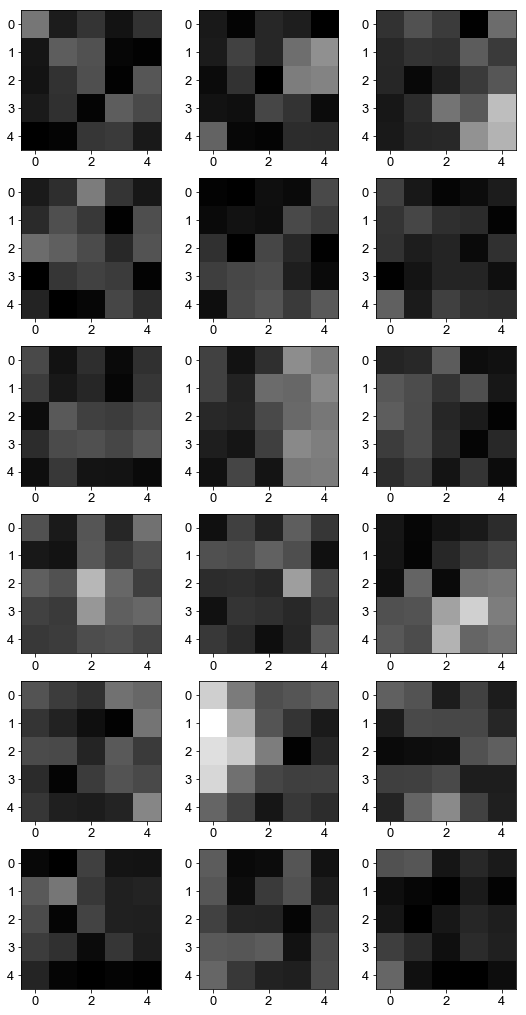

In [57]:
visualize_conv_weights(weights, filter_size=5, num_channels=20)

In [5]:
def fully_connected(pool=4, num_channels=10, verbose=True, return_weights=False, reg_kind=None, reg_value=None):
    
    d = int(784/pool**2)
    x = tf.placeholder(tf.float32, [None, 784])


    #hidden layer
    W_fc1 = get_variable([d, d*num_channels])
    b_fc1 = get_variable([d*num_channels])
    # W_fc1 = weight_variable([784, 7840])
    # b_fc1 = bias_variable([7840])
    x_reshaped = tf.reshape(x, [-1, 28, 28, 1])
    x_reshaped = tf.nn.max_pool(x_reshaped, [1, pool, pool,1], [1, pool, pool, 1], padding='SAME')
    x_reshaped = tf.reshape(x_reshaped, [-1, d])
    h_fc1 = tf.sigmoid(tf.matmul(x_reshaped, W_fc1) + b_fc1)

    #output layer
    W_fc2 = get_variable([d*num_channels, 10])
    # W_fc2 = weight_variable([7840, 10])
    b_fc2 = get_variable([10])
    y = tf.matmul(h_fc1, W_fc2) + b_fc2

    y_ = tf.placeholder(tf.float32, [None, 10])
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
    loss = regularize(loss, W_fc1, reg_kind, reg_value)
    train_step = tf.train.GradientDescentOptimizer(3.0).minimize(loss)

    with tf.Session() as sess:
        tf.global_variables_initializer().run()

        correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        for i in range(1500):
            batch = mnist.train.next_batch(100)
            train_step.run(feed_dict={x: batch[0], y_: batch[1]})
            if i%100==0:
                accuracy_train = accuracy.eval(feed_dict={x: mnist.train.images, y_: mnist.train.labels})
                accuracy_valid = accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels})
                if verbose:
                    print('Train acc:',accuracy_train, 'Valid acc:',accuracy_valid)
        
        return_values = [accuracy_train, accuracy_valid]
        if return_weights:
            return_values.append(sess.run(W_fc1))
        
    return return_values

In [58]:
accuracy_train, accuracy_valid, weights = fully_connected(return_weights=True, num_channels=20)

Train acc: 0.124 Valid acc: 0.1159
Train acc: 0.6629091 Valid acc: 0.6714
Train acc: 0.8190727 Valid acc: 0.8215
Train acc: 0.80538183 Valid acc: 0.8052
Train acc: 0.83205456 Valid acc: 0.8332
Train acc: 0.7968909 Valid acc: 0.7923
Train acc: 0.86047274 Valid acc: 0.8579
Train acc: 0.82354546 Valid acc: 0.8162
Train acc: 0.8709273 Valid acc: 0.8641
Train acc: 0.8835091 Valid acc: 0.8807


In [6]:
for num_channels in [5, 10, 20, 32, 64, 128]:
    for i in range(3):
        accuracy_train, accuracy_valid = fully_connected(verbose=False, num_channels=num_channels)
        print(num_channels, accuracy_valid)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

5 0.866
5 0.8822
5 0.8791
10 0.869
10 0.8843
10 0.8664
20 0.8756
20 0.8368
20 0.8386
32 0.8591
32 0.8695
32 0.8804
64 0.8864
64 0.8121
64 0.8585
128 0.7936
128 0.7941
128 0.8401
